## Quickstart

Install dependencies:

```shell
pip install jupyter altair altair_saver polars pyarrow anywidget ipywidgets
```

Then, as per the [CAIS tutorial](https://cluster.safe.ai/#jupyter-notebooks-on-the-cluster), start a new interactive node:

```shell
srun --partition=single --pty bash
```

Then note the port number from:

```shell
unset XDG_RUNTIME_DIR
export NODEPORT=$(( $RANDOM + 1024 ))
echo $NODEPORT
jupyter notebook --no-browser --port=$NODEPORT
```

Then on you local machine run (filling in the port from above).

```shell
export NODEPORT=####
ssh -t -t [your ssh alias for cais cluster] -L ${NODEPORT}:localhost:${NODEPORT} ssh -N compute-permanent-node-990 -L ${NODEPORT}:localhost:${NODEPORT}
```

Now, open your local browser and enter the URL from jupyter (`http://localhost:19303/?token=cb...`), or open VSCode and under Select Kernel choose "Existing Jupyter Server" and input it there.

In [1]:
from pathlib import Path

import altair as alt
import polars as pl
import sklearn.metrics as skm
from IPython.display import clear_output, display
from ipywidgets import HTML, Dropdown, HBox, Label, Output, VBox, Video

Below are some helper function that are not very important.

In [2]:
def _metadata_cols(df: pl.DataFrame):
    tasks = df.get_column("task").unique().to_list()
    default = [
        "path",
        "task",
        "model",
        "reward",
        "label",
        "true_probability",
        "probability",
    ]
    return [c for c in df.columns if c not in tasks + default]


def _max_prob(df: pl.DataFrame, col: str):
    return df.group_by(["path", "task", "model", "reward"]).agg(
        # Extract the label with the highest probability
        pl.col("label").sort_by(col).last(),
        pl.col(_metadata_cols(df)).first(),
    )

By default, the latest experiment in `out` is loaded. You can change this manually.

In [3]:
# Load the latest experiment
# experiments = Path("../../out").iterdir()
experiments = Path("/data/datasets/habitat_experiments/").iterdir()

latest_experiment = sorted(experiments, key=lambda d: d.stat().st_mtime)[-1]
experiment_dir = latest_experiment
# #experiment_dir = Path("/data/datasets/habitat_experiments/Exp_20240313_090224")
# experiment_dir = Path("/data/datasets/habitat_experiments/Exp_20240313_164744")

df = pl.read_csv(experiment_dir / "results.csv")

FileNotFoundError: No such file or directory (os error 2): ../../out/Exp_20240313_084045/results.csv

In [4]:
df

task,model,reward,label,probability,true_probability,path,is_photorealistic,needs_temporal
str,str,str,str,f64,i64,str,bool,bool
"""room_detection…","""gpt4""","""default""","""bathroom""",0.231969,1,"""/data/datasets…",true,false
"""room_detection…","""gpt4""","""default""","""bedroom""",0.085337,0,"""/data/datasets…",true,false
"""room_detection…","""gpt4""","""default""","""dining_room""",0.085337,0,"""/data/datasets…",true,false
"""room_detection…","""gpt4""","""default""","""closet""",0.085337,0,"""/data/datasets…",true,false
"""room_detection…","""gpt4""","""default""","""garage""",0.085337,0,"""/data/datasets…",true,false
…,…,…,…,…,…,…,…,…
"""stairs_directi…","""viclip""","""projection_1.0…","""stairs_down""",0.962531,0,"""/data/datasets…",true,true
"""stairs_directi…","""viclip""","""projection_1.0…","""stairs_up""",0.978567,1,"""/data/datasets…",false,true
"""stairs_directi…","""viclip""","""projection_1.0…","""stairs_down""",0.956796,0,"""/data/datasets…",false,true


In [5]:
predicted_labels = _max_prob(df, "probability").rename({"label": "predicted_label"})
true_labels = _max_prob(df, "true_probability").rename({"label": "true_label"})
predictions = predicted_labels.join(
    true_labels, on=["path", "task", "model", "reward"]
)

We created the table `predictions`, containing the predictions of all model+reward combinations for all tasks and videos. Most visualizations will be okay with using this as a base.

In [6]:
predictions.head(3)

path,task,model,reward,predicted_label,true_label
str,str,str,str,str,str
"""/data/datasets…","""room_detection…","""gpt4""","""default""","""bedroom""","""bedroom"""
"""/data/datasets…","""room_detection…","""gpt4""","""default""","""kitchen""","""kitchen"""
"""/data/datasets…","""room_detection…","""gpt4""","""default""","""living_room""","""office"""


### Adding a baseline model (majority class)

In [7]:
# I take the mode, and if there is more than two classes with same count, I select the first class
task_to_majority_prediction = predictions.group_by("task").agg(
    pl.col("true_label")\
        .mode()\
        .map_elements(lambda x: x[0])\
        .alias("predicted_label")
)
task_to_majority_prediction

task,predicted_label
str,str
"""interact_open""","""open"""
"""has_toilet""","""yes"""
"""stairs_directi…","""stairs_down"""
"""has_plant""","""no"""
"""interact_drop""","""return"""
"""clip_through_d…","""normal"""
"""has_tv""","""no"""
"""room_detection…","""bedroom"""


In [8]:
# Now let's make a copy of gpt4 answers and replace all predicted labels with majority prediction
majority_model = predictions.filter(predictions["model"] == "gpt4").drop("predicted_label").join(task_to_majority_prediction, on=["task"])
majority_model = majority_model.with_columns(model=pl.lit("majority_baseline"))

# And reorder columns to be able to concatenate this with original predictions 
majority_model = majority_model.drop("predicted_label").insert_column(-1, majority_model.get_column("predicted_label"))
majority_model

path,task,model,reward,predicted_label,true_label
str,str,str,str,str,str
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""bedroom"""
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""kitchen"""
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""office"""
"""/data/datasets…","""has_plant""","""majority_basel…","""default""","""no""","""no"""
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""bedroom"""
…,…,…,…,…,…
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""bedroom"""
"""/data/datasets…","""room_detection…","""majority_basel…","""default""","""bedroom""","""hall"""
"""/data/datasets…","""clip_through_d…","""majority_basel…","""default""","""normal""","""normal"""


In [9]:
predictions = pl.concat([predictions, majority_model])

Based on `predictions`, we can calculate metrics for each task, model, reward combination. Feel free to add more here!

In [10]:
# A wrapper around a sklearn metric function
def f1(group: pl.Series):
    # group is a pl.Series object with two named fields, true_label and predicted_label
    # we can access those fields using group.struct.field
    return skm.f1_score(
        y_true=group.struct.field("true_label").to_numpy(),
        y_pred=group.struct.field("predicted_label").to_numpy(),
        average="macro",
    )

# A wrapper around a sklearn metric function
def accuracy(group: pl.Series):
    # group is a pl.Series object with two named fields, true_label and predicted_label
    # we can access those fields using group.struct.field
    return skm.accuracy_score(
        y_true=group.struct.field("true_label").to_numpy(),
        y_pred=group.struct.field("predicted_label").to_numpy(),
    )



# A helper function used to extract label colums from the dataframe,
# package them as structs, and then map matric_fun over them
def compute_metric(metric_fun):
    return pl.struct("true_label", "predicted_label").map_batches(metric_fun).first()

### Making summary plots

In [11]:
# I [Mike] am just more experienced with those
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
n_classes_per_task = predictions.group_by("task").agg(pl.col("true_label").n_unique().alias("n_classes"))
n_classes_per_task

task,n_classes
str,u32
"""clip_through_d…",2
"""stairs_directi…",2
"""has_tv""",2
"""interact_drop""",4
"""room_detection…",10
"""has_plant""",2
"""has_toilet""",2
"""interact_open""",3


In [13]:
binary_tasks = n_classes_per_task.filter(n_classes_per_task["n_classes"] == 2)["task"].to_list()
binary_tasks

['clip_through_detection',
 'stairs_direction',
 'has_tv',
 'has_plant',
 'has_toilet']

In [14]:
multiclass_tasks = n_classes_per_task.filter(n_classes_per_task["n_classes"] != 2)["task"].to_list()
multiclass_tasks

['interact_drop', 'room_detection', 'interact_open']

In [15]:
# for consistent ordering of the models on the plots
MODEL_ORDER = {
    "majority_baseline": 0,
    "clip": 1,
    "viclip": 2,
    "s3d": 3,
    "gpt4": 4,
}

def make_summary_plot(predictions, task_set, plot_name, metric_name, selected_reward_type, n_cols=2, figsize=(14, 10), dpi=200):
    plt.figure(figsize=figsize, dpi=dpi)
    
    n_rows = (len(task_set) + n_cols - 1) // n_cols
    
    for i, task in enumerate(task_set):
        plt.subplot(n_rows, n_cols, i+1)
    
        metrics = predictions\
            .filter((predictions["task"] == task) & ((predictions["reward"] == selected_reward_type) | (predictions["reward"] == "default")))\
            .group_by("model")\
            .agg(
                f1=compute_metric(f1),
                accuracy=compute_metric(accuracy)
            )

        metrics = metrics.sort(pl.col("model").replace(MODEL_ORDER))

        ax = sns.barplot(metrics, y=metric_name, x="model", hue="model", palette="muted")
        ax.axhline(y=metrics[MODEL_ORDER["majority_baseline"], metric_name], ls="--")
        plt.xlabel("")
        plt.ylabel("")
        plt.title(task, fontsize=18)
        plt.xticks(rotation=20, ha="right")
    
    plt.suptitle(plot_name, fontsize=22)
    plt.tight_layout()

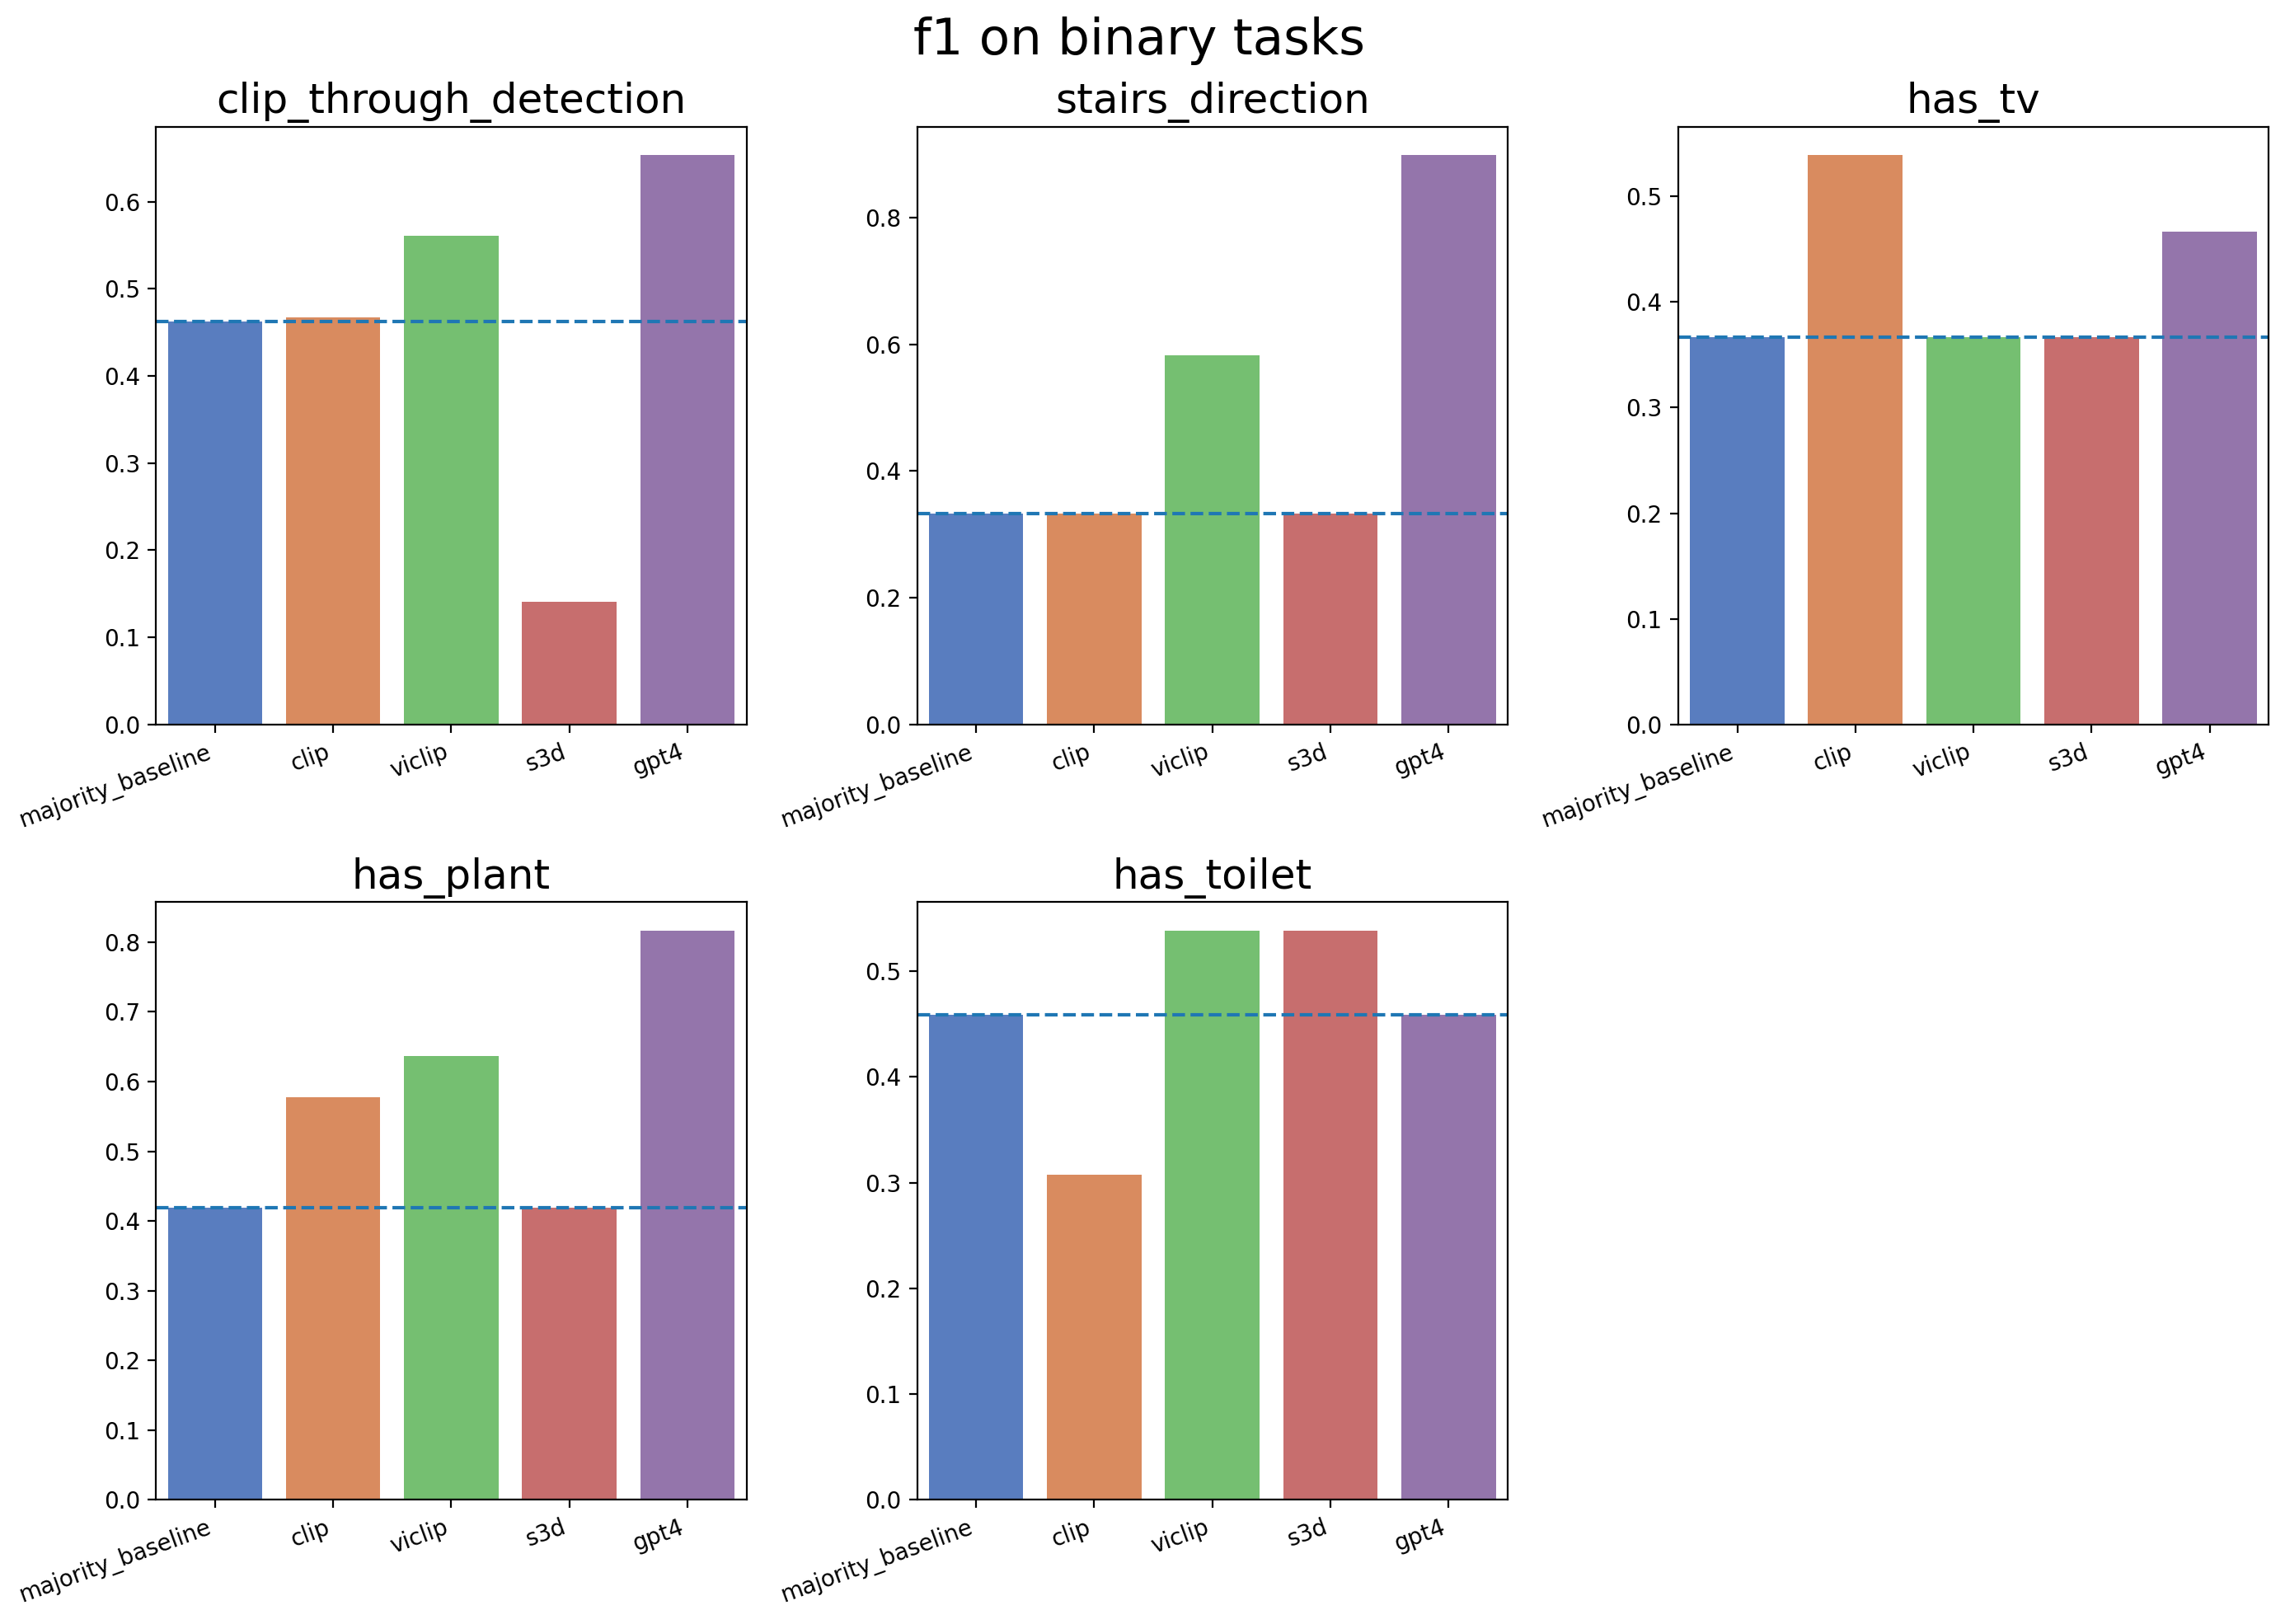

In [16]:
make_summary_plot(predictions, binary_tasks, "f1 on binary tasks", metric_name="f1", selected_reward_type="logit", n_cols=3)

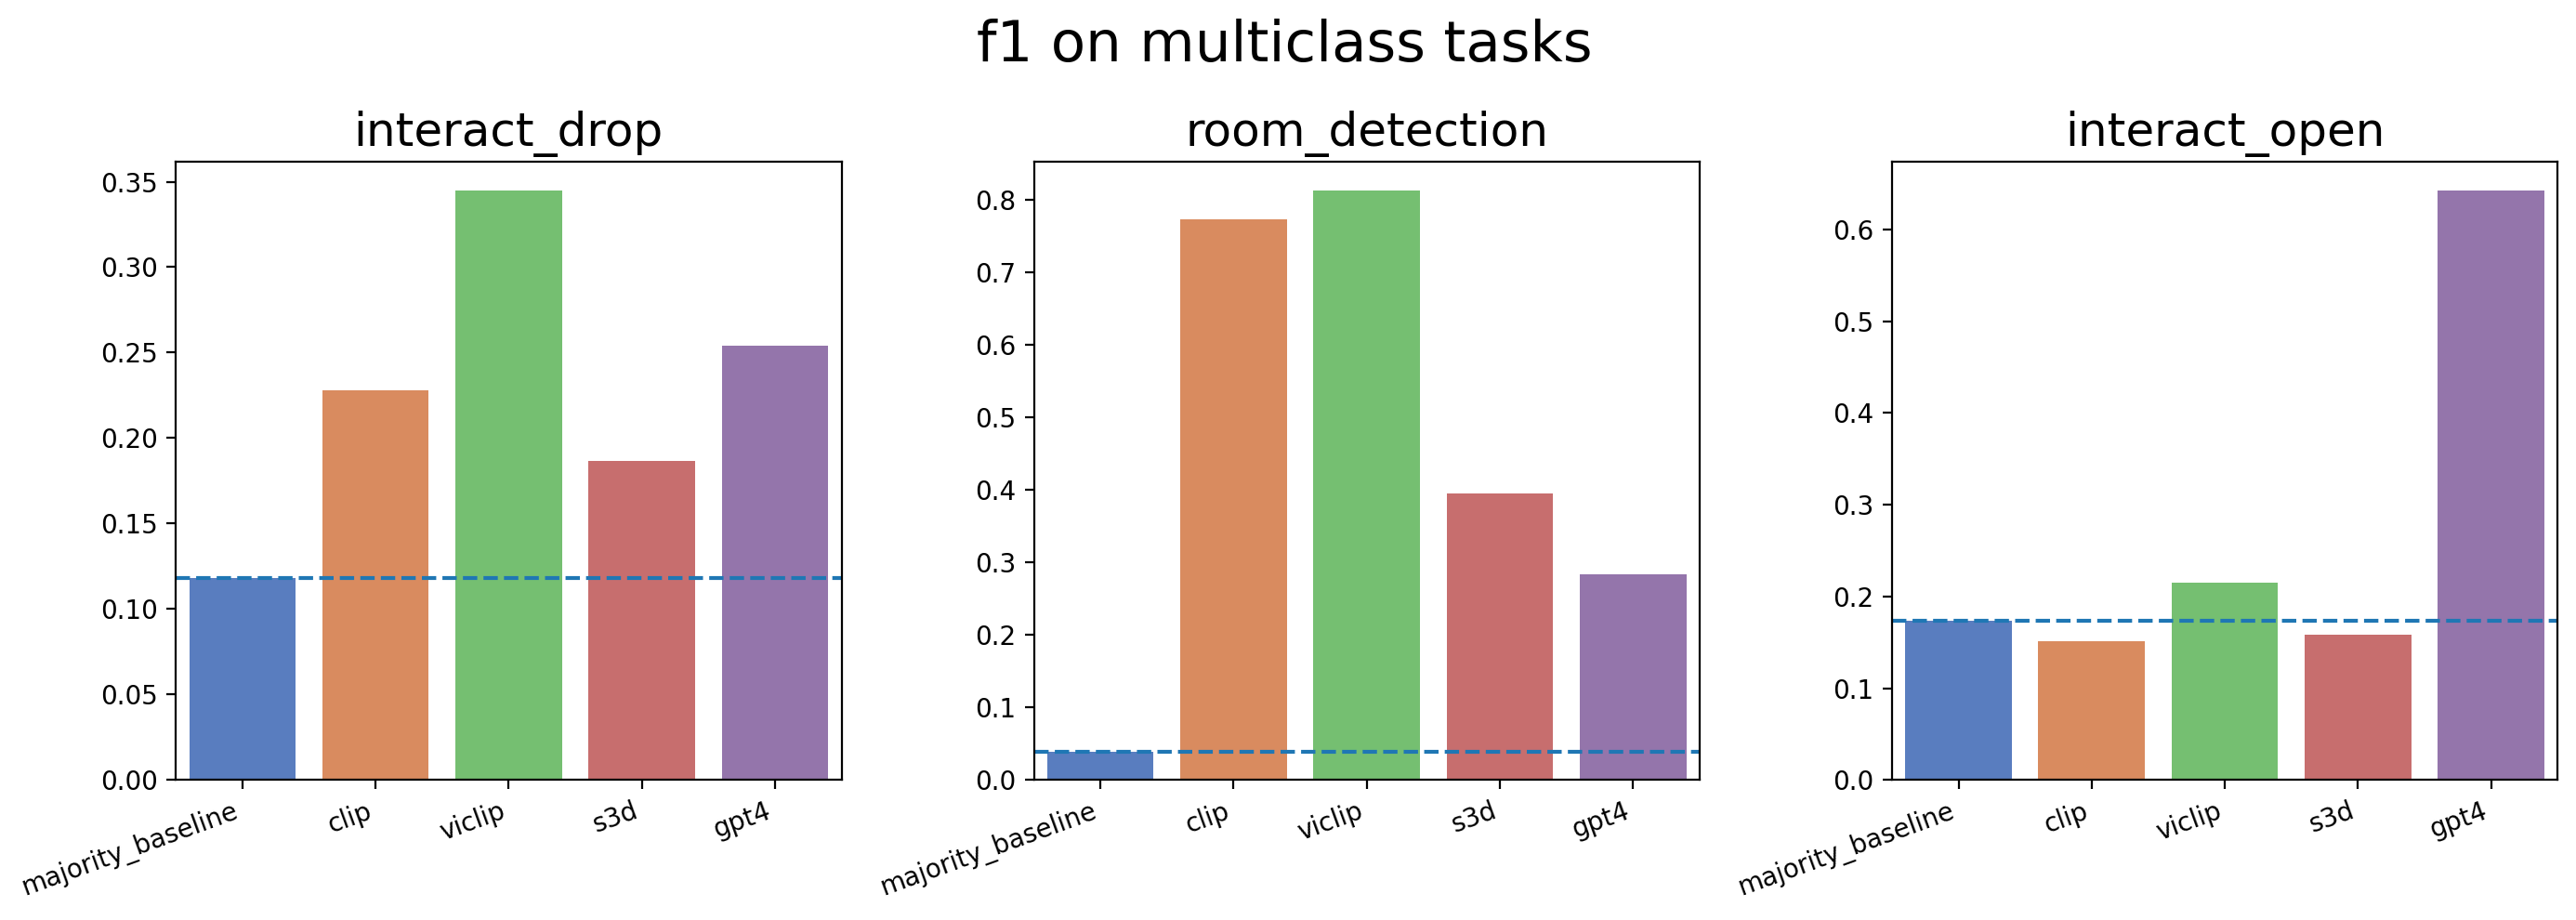

In [17]:
make_summary_plot(predictions, multiclass_tasks, "f1 on multiclass tasks", metric_name="f1", selected_reward_type="logit", n_cols=3, figsize=(14, 5))

### Cool Evžen's plots

Now that we have a table with metrics, we can plot it. We use `altair` because it allows for the type of interactivity we need later.

In [18]:
metrics = predictions.group_by("task", "model", "reward").agg(
    f1=compute_metric(f1)
    # ...add more here!
)

metrics.head(3)

task,model,reward,f1
str,str,str,f64
"""interact_open""","""clip""","""projection_0.5…",0.151515
"""room_detection…","""s3d""","""projection_1.0…",0.010853
"""has_toilet""","""clip""","""projection_0.7…",0.133333


In [19]:
def plot_metric(metric_name):
    return (
        alt.Chart(metrics.to_pandas())
        .mark_bar(width=10)
        .encode(
            x="reward",
            y=metric_name,
            color="model",
            tooltip=[metric_name, "model", "reward"],
        )
        .facet(column="model", row="task")
        .properties(title="F1 score")
    )


plot_metric("f1")

alt.FacetChart(...)

We can also make the plot above but compute the metrics separately based on different metadata values, e.g. `is_photorealistic`. For brevity, we only plot the best-performing model+reward combination per model.

In [7]:
metrics_per_photorealistic = predictions.group_by(
    "task", "model", "reward", "is_photorealistic"
).agg(
    f1=compute_metric(f1),
    # ...add more here!
)

best_models = metrics.group_by("task", "model").agg(
    pl.col("reward").sort_by("f1", descending=True).first()
)

# The metrics_per_photorealistic table filtered to only contain the best models
# i.e. exactly one model+reward per task+is_photorealistic
metrics_per_photorealistic = metrics_per_photorealistic.join(
    best_models, on=["task", "model", "reward"], how="semi"
).with_columns(evaluator=pl.concat_str("model", "reward", separator=" + "))

(
    alt.Chart(metrics_per_photorealistic.to_pandas(), width=160)
    .mark_bar(width=10)
    .encode(
        x=alt.X("f1", title="Macro-averaged F1 Score"),
        y=alt.Y("evaluator", title=""),
        color="model",
        tooltip=["f1", "model", "reward"],
    )
    .facet(row=alt.Row("task", title="Task"), column=alt.Column("is_photorealistic", title="Was the video photorealistic?"))
    .resolve_scale(y="independent")
    .properties(title="F1 Score in Different Tasks, Photorealistic v. CAD Model")
)

alt.FacetChart(...)

Most of the plotting needs will probably be taken care of by the above, or small variations of it. Below we have the interactive confusion matrix; the code there shouldn't be too important to fully understand.

In [20]:
def chart(task, model, metrics):
    # A table of best model+reard combination for each model and task
    best_models = metrics.group_by("task", "model").agg(
        pl.col("reward").sort_by("f1", descending=True).first()
    )

    # The predictions table filtered to only contain the best models
    # i.e. exactly one model+reward per task
    best_model_predicitons = predictions.filter(
        pl.col("task") == task, pl.col("model") == model
    ).join(best_models, on=["task", "model", "reward"], how="semi")

    true_label_size = best_model_predicitons.group_by(
        "model", "reward", "true_label"
    ).agg(pl.len().alias("true_label_size"))

    # A normal confusion matrix
    confusion_matrix = (
        best_model_predicitons.join(
            true_label_size, on=["model", "reward", "true_label"]
        )
        .group_by("model", "reward", "true_label", "predicted_label")
        .agg(count=pl.len(), ratio=pl.len() / pl.col("true_label_size").first())
    )

    # Needed to register the click events
    selection = alt.selection_point(
        fields=["true_label", "predicted_label"], name="selection"
    )

    # Base chart to which we'll add layers later
    base = (
        alt.Chart(confusion_matrix.to_pandas())
        .encode(
            x="predicted_label",
            y="true_label",
        )
        .properties(title=f"{model}, {task}")
    )

    # Heatmap layer
    heatmap = base.mark_rect().encode(
        color=alt.Color("ratio").scale(scheme="blues"),
        tooltip=["true_label", "predicted_label", "count", "ratio"],
    )

    # Diagonal frames layer
    labels = confusion_matrix["true_label"].unique()
    diag_df = pl.DataFrame({"predicted_label": labels, "true_label": labels})
    diagonal = (
        alt.Chart(pl.DataFrame(diag_df).to_pandas())
        .mark_rect(stroke="black", strokeWidth=1, fillOpacity=0)
        .encode(x="predicted_label", y="true_label")
    )

    # Text labels in cells
    text = base.mark_text(baseline="middle").encode(
        alt.Text("ratio", format=".1~f"),
        color=alt.condition(
            alt.datum.ratio < 0.5, alt.value("black"), alt.value("white")
        ),
    )

    # Add the layers together and also add the click-selector from eariler
    # Returning this would give us a normal chart, like the one above
    chart = (heatmap + diagonal + text).add_params(selection)

    # Wrap the chart in a Jupyter widget
    jchart = alt.JupyterChart(chart)

    # This is the vertical box the videos will live in
    videos_widget = VBox()

    # Click callback
    def on_select(change):
        if change.new.value is None:
            return

        paths = []

        for sel in change.new.value:
            # Get a list of videos that correspond to the cell that was clicked on
            paths.extend(
                best_model_predicitons.filter(
                    pl.col("model") == model,
                    pl.col("task") == task,
                    pl.col("true_label") == sel["true_label"],
                    pl.col("predicted_label") == sel["predicted_label"],
                )
                .get_column("path")
                .to_list()
            )
        # Load the videos based on the paths above, and put them into a flexbox
        videos = []
        for path in paths:
            video = Video.from_file(path)
            video.autoplay = True
            video.loop = True
            videos.append(VBox([video, Label("👆 " + path)]))

        videos_widget.children = videos

    # Whenever the selection in the chart changes, call the callback above
    jchart.selections.observe(on_select, ["selection"])

    return HBox([jchart, videos_widget])

When you run the cell below, you can pick the model and task combination and also click the cells in the matrix to see which videos ended up in them.

In [21]:
# Create a task selection dropdown
tasks = predictions.get_column("task").unique().sort()
task_dropdown = Dropdown(
    options=tasks,
    value=tasks[0],
    description="Task:",
)

# Create a model selection dropdown
models = predictions.get_column("model").unique().sort()
model_dropdown = Dropdown(
    options=models,
    value=models[0],
    description="Model:",
)

# Create an "output", a sort of a canvas that we can render things into
# This is needed for the live updates whenever the dropdowns change
output = Output()


def on_change(_change):
    with output:
        # Clear the canvas and render the new plot
        clear_output()
        display(chart(task_dropdown.value, model_dropdown.value, metrics))


model_dropdown.observe(on_change, names=["value"])
task_dropdown.observe(on_change, names=["value"])

# Render the dropdowns in Jupyter
display(VBox([task_dropdown, model_dropdown]))

with output:
    # Redner the chart into the output
    display(chart(task_dropdown.value, model_dropdown.value, metrics))

# Render the output in Jupyter
output

Output()